In [1]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
initializers = tf.keras.initializers

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data_generator import generator
from encoding.layers import IntegerBaseEncoder, FloatBaseEncoder

2023-02-08 16:14:57.117740: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
seed = 123
tf.random.set_seed(seed)
n_samples = 1000
n_features = 1
mean = 1
std = 0.6

for dist_name in ['normal', 'exponential', 'lognormal']:
    gen = generator.DataGenerator(mean=mean, std=std, dist=dist_name)
    x, y = gen.generate(n_features=n_features, n_samples=n_samples)
    x = np.ravel(x)
    order = np.argsort(x).reshape(-1, 1)
    x, y = x[order], y[order]
    exec(f'x_{dist_name}=x\ny_{dist_name}=y')

In [3]:
x_array = ['x_normal', 'x_exponential', 'x_lognormal']
y_array = ['y_normal', 'y_exponential', 'y_lognormal']

In [4]:
standard = lambda x:(x - x.mean())/x.std()

transform_layer = FloatBaseEncoder()
transform_layer_only_integers = FloatBaseEncoder(only_integers=True)
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'binary explosion o/i': lambda x: transform_layer_only_integers(x).squeeze(1),
                  'higher dimensionality': lambda x, n=5: np.power(x, np.arange(1, n))}

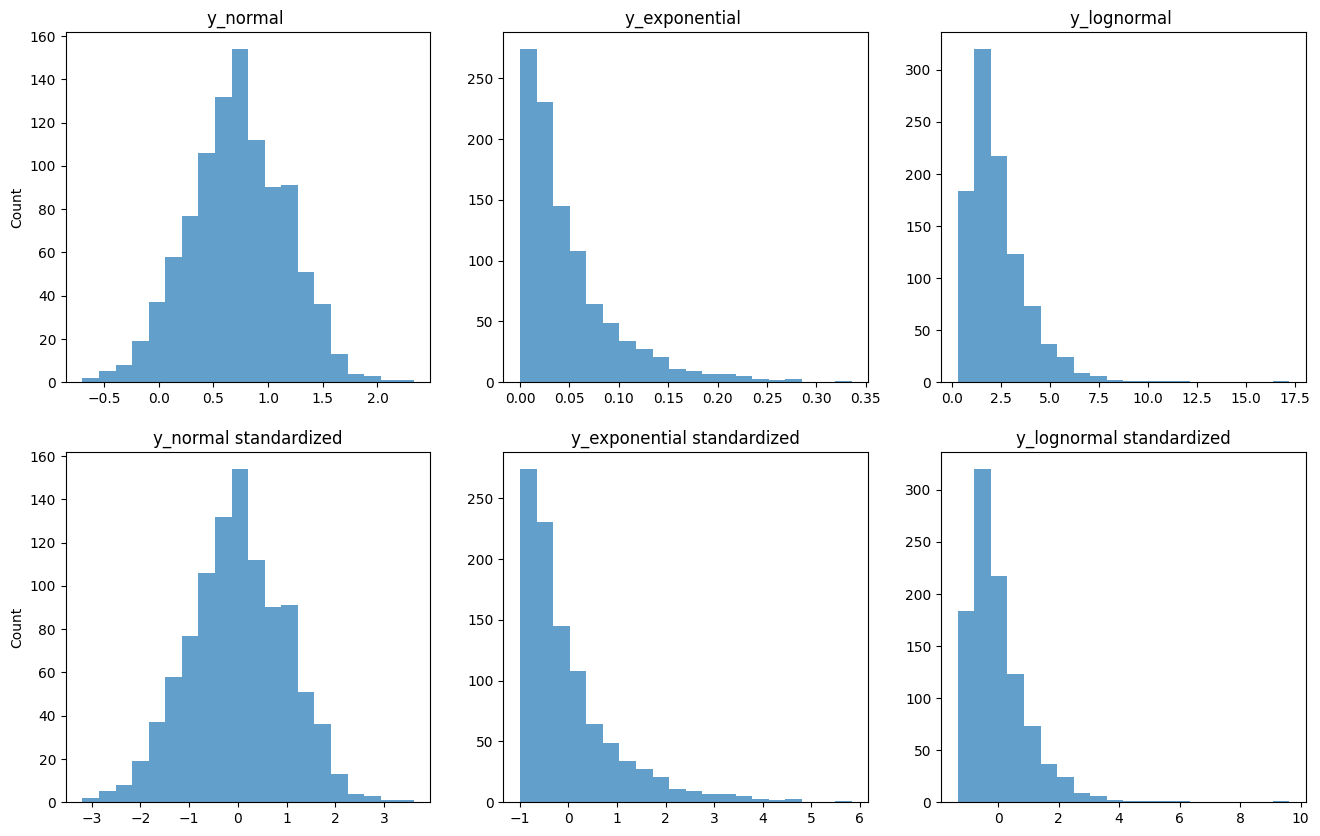

In [5]:
fig, ax = plt.subplots(2, len(y_array), figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate(y_array):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

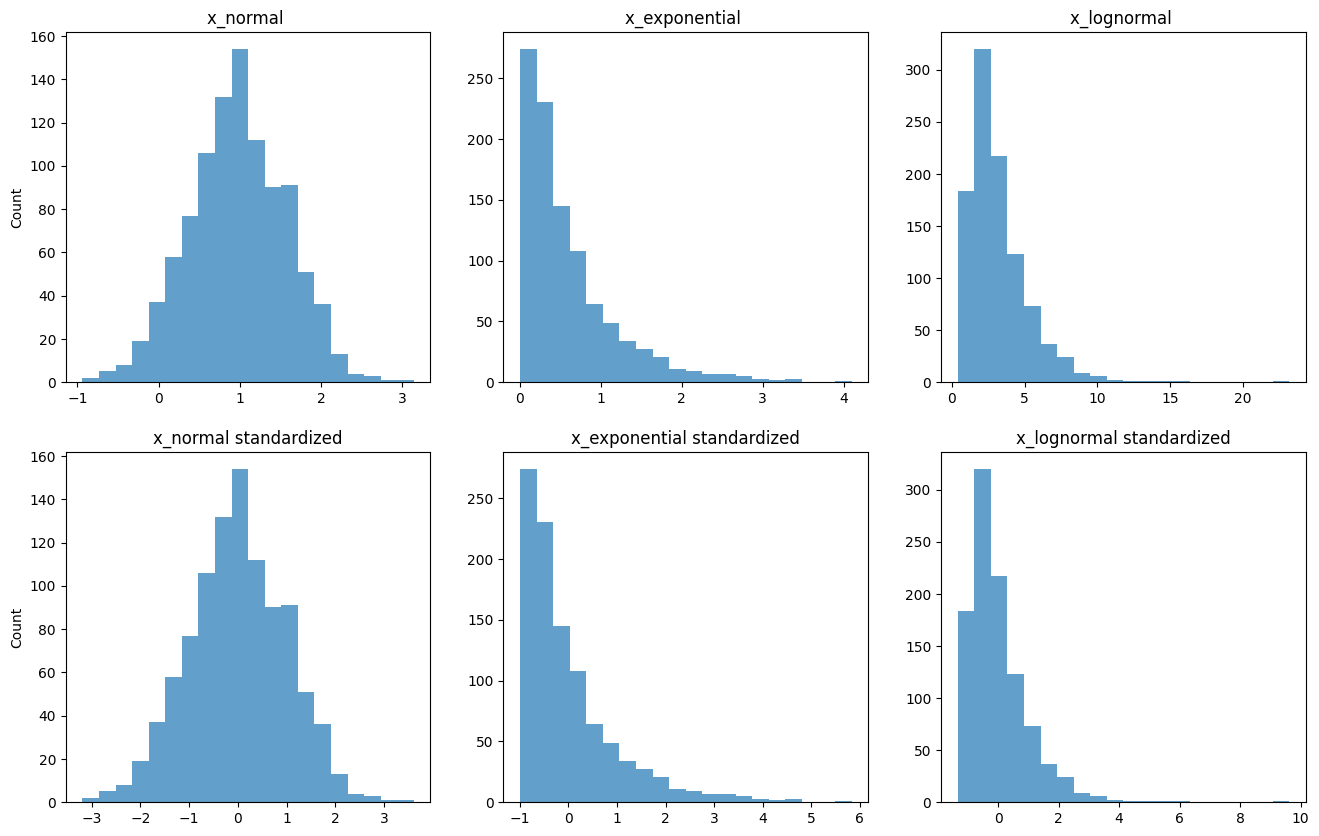

In [6]:
fig, ax = plt.subplots(2, len(x_array), figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate(x_array):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

In [7]:
# fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
# fig.tight_layout()


# baseline = LinearRegression

# for idx, x_name in enumerate(x_array):
#     for idy, y_name in enumerate(y_array):
#         cur_x, cur_y = eval(x_name), eval(y_name)

#         for name_transformation, func_transformation in tranformations.items():
#             transformed_x = func_transformation(cur_x)
            
#             model = baseline()
#             model.fit(transformed_x, cur_y)
                        
#             y_hat = model.predict(transformed_x)
#             score = model.score(transformed_x, cur_y)
#             ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=2, label=f'{score:0.3f} : {name_transformation}')


#         ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

#         ax[idx, idy].set_title(f'{x_name}/{y_name}')
#         ax[idx, idy].legend()
# plt.suptitle('Linear Regression', y=1.02)
# plt.show()

In [8]:
class _MLPBlock(keras.layers.Layer):
    def __init__(self, width, droprate=0, regularization=keras.regularizers.L1L2(0), **kwargs):
        super(_MLPBlock, self).__init__()
        self.dense = layers.Dense(width, 
                                  kernel_initializer=initializers.RandomNormal(seed=seed),
                                  kernel_regularizer=regularization, **kwargs)
#         self.activation = layers.ReLU()
#         self.drop = layers.Dropout(droprate)
#         self.bn = layers.BatchNormalization()
        
    def call(self, inputs, **kwargs):
        x = self.dense(inputs)
#         x = self.activation(x)
#         x = self.drop(x)
#         x = self.bn(x)
        return x

# implement policy network
class MLP(keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=64, depth=1, **kwargs):
        super().__init__()
        self.depth = depth
        self.hidden_0 = _MLPBlock(hidden_dim, input_shape=(input_dim,), **kwargs)

        for i in range(1, depth):
            setattr(self, f'hidden_{i}', _MLPBlock(hidden_dim))
        self.out = _MLPBlock(output_dim)

    
    def call(self, inputs):
        x = inputs
        for i in range(self.depth):
            x = getattr(self, f'hidden_{i}')(x)
        x = self.out(x)
        return x

In [9]:
# fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
# fig.tight_layout()


# activation = activation=keras.activations.relu


# for idx, x_name in enumerate(x_array):
#     for idy, y_name in enumerate(y_array):
#         cur_x, cur_y = eval(x_name), eval(y_name)
        

#         for name_transformation, func_transformation in tranformations.items():
#             transformed_x = func_transformation(cur_x)
#             try:
#                 model = MLP(transformed_x.shape[1], 1, 1024, depth=2, activation=activation)
#                 model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
#                 model.fit(transformed_x, cur_y, epochs=1000, verbose=0)
#                 y_hat = model.predict(transformed_x)
#                 score = mse(y_hat, cur_y)
#                 print(f"{score} : {name_transformation}")
#                 ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
#             except:
#                 print(name_transformation, 'NANS')


#         ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

#         ax[idx, idy].set_title(f'{x_name}/{y_name}')
#         ax[idx, idy].legend()
# plt.suptitle('MLP', y=1.02)
# plt.show()

3.1266924642972506e-08 : intact
2.897631200533265e-08 : standardization
6.243370084515154e-05 : binary explosion
0.0063450524289318955 : binary explosion o/i
0.001896237088361332 : higher dimensionality
7.145079123251442e-05 : intact
9.338769696871715e-06 : standardization
1.4624936800517275e-05 : binary explosion
0.0002738019522615679 : binary explosion o/i
4.518433777516884e-05 : higher dimensionality
0.005494165219730007 : intact
0.014601537731642054 : standardization
0.03693376239367369 : binary explosion
0.00015175946706126454 : binary explosion o/i
3.41665596681508e-06 : higher dimensionality
0.0017614452426537057 : intact
0.0021888323149138623 : standardization
0.00011006916585548461 : binary explosion
0.0004291874794779308 : binary explosion o/i
0.06553169847637721 : higher dimensionality
3.0428248961953135e-06 : intact
8.668144620289958e-09 : standardization
8.871268971824999e-07 : binary explosion
0.0007552445279447389 : binary explosion o/i
0.0031563026599198568 : higher dim

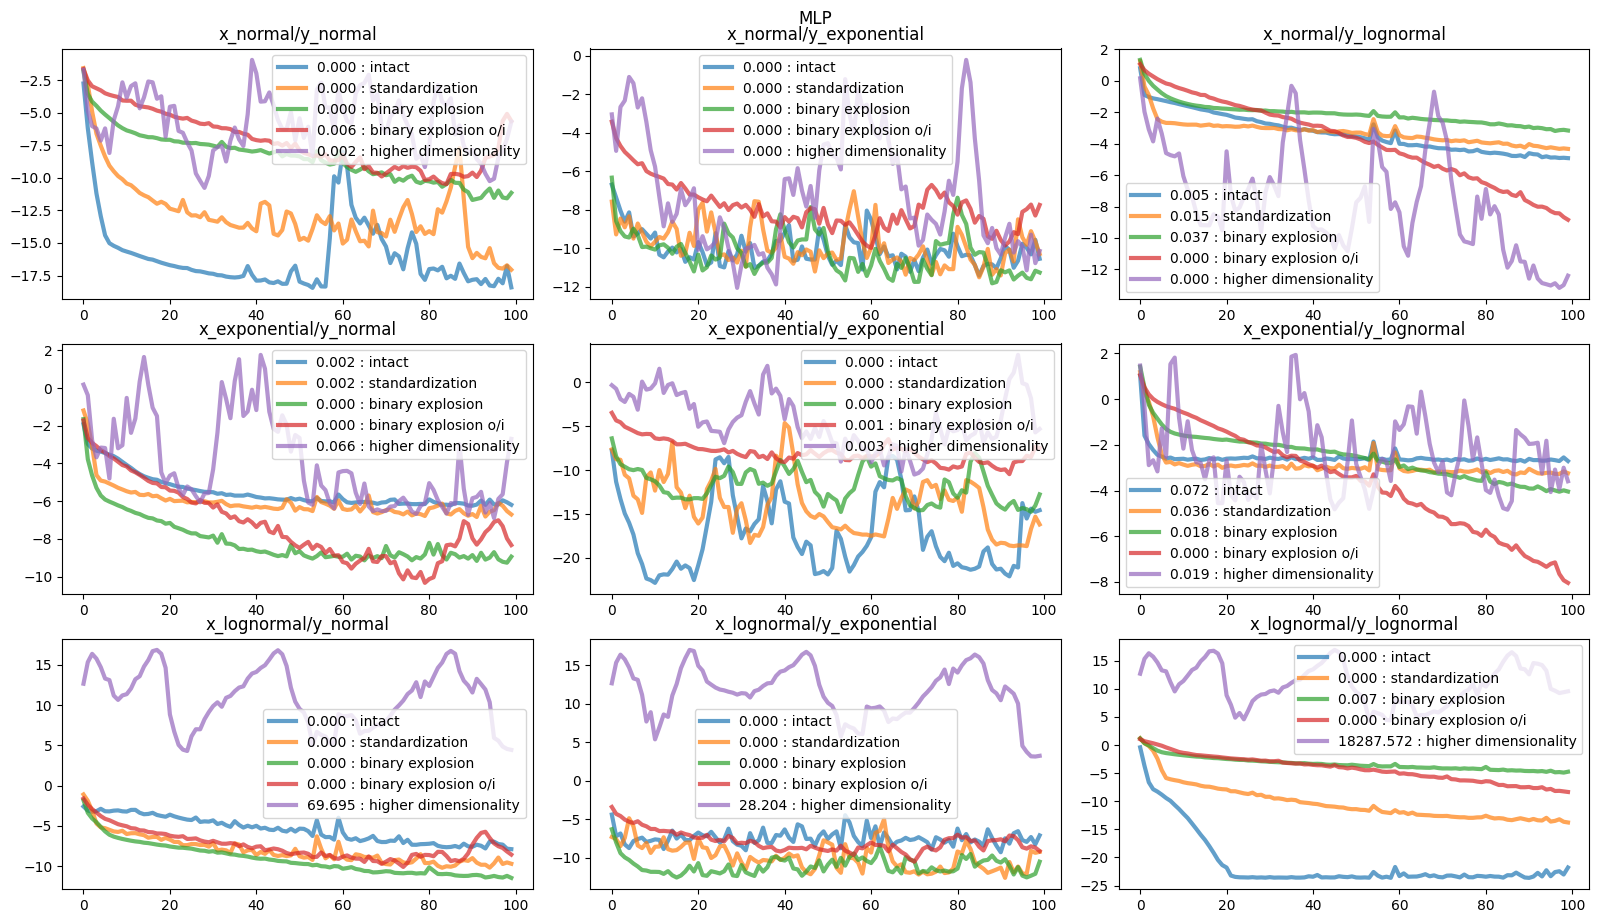

In [11]:
fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()
epochs = 100

activation = activation=keras.activations.relu


for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)
        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            model = MLP(transformed_x.shape[1], 1, 1024, depth=2, activation=activation)
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
            history = model.fit(transformed_x, cur_y, epochs=epochs, verbose=0)
            y_hat = model.predict(transformed_x)
            score = mse(y_hat, cur_y)
            print(f"{score} : {name_transformation}")
            ax[idx, idy].plot(np.log(history.history['loss']), alpha=0.7, linewidth=2, label=f'{score:0.3f} : {name_transformation}')



#         ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()

In [ ]:
string = '''4.859725075452633e-07 : intact
4.739567539021307e-06 : standardization
1.9313169298821564e-06 : binary explosion
3.136825034534401e-05 : binary explosion o/i
7.663368255294092e-07 : higher dimensionality
3.002665799070065e-06 : intact
2.7552542912349115e-06 : standardization
2.2479403867260875e-06 : binary explosion
1.8174747504392402e-05 : binary explosion o/i
1.9725665975781786e-06 : higher dimensionality
9.463978497959135e-05 : intact
0.00017913093813308153 : standardization
0.004165188522202954 : binary explosion
0.0010180907657026895 : binary explosion o/i
2.002859163127305e-06 : higher dimensionality
0.0010296399164143562 : intact
0.00031296169588980054 : standardization
5.6762450294421226e-05 : binary explosion
3.678967141922036e-05 : binary explosion o/i
0.0007034809739709907 : higher dimensionality
2.7910889642164254e-09 : intact
2.4407092915107915e-09 : standardization
5.9956416919595235e-06 : binary explosion
3.2394498904564015e-06 : binary explosion o/i
4.382038401623967e-06 : higher dimensionality
0.0085891436120493 : intact
0.0047529009822582236 : standardization
0.007380643328424869 : binary explosion
0.00018891866402399648 : binary explosion o/i
0.00387129168945408 : higher dimensionality
8.161441806276957e-06 : intact
4.002413797973502e-06 : standardization
1.0562107856816042e-06 : binary explosion
5.508702802093663e-06 : binary explosion o/i
10.612768036426921 : higher dimensionality
1.2761571804958851e-05 : intact
3.911245862905662e-06 : standardization
2.152050439472231e-06 : binary explosion
3.222959399868741e-06 : binary explosion o/i
0.7370006894801239 : higher dimensionality
9.100245867829842e-06 : intact
4.07233172298398e-07 : standardization
4.2637525228370126e-05 : binary explosion
0.0038776578938894703 : binary explosion o/i
0.829572496282701 : higher dimensionality
'''

In [ ]:
import re 
from itertools import product

In [ ]:
re_pattern = "(.*) : ([\w\s\/]*)\n"

In [ ]:
ff = np.array(re.findall(re_pattern, string))

In [ ]:
import pandas as pd

In [ ]:
x_temp = np.array([[x]*5*3 for x in x_array]).ravel()

In [ ]:
arrays = np.hstack([x_temp.reshape(-1, 1), np.array(y_array*15).reshape(-1, 1)])

In [ ]:
# index = pd.MultiIndex.from_arrays(arrays.T, names=['x_array', 'y_array'])
df = pd.DataFrame(ff, columns=['result', 'preprocessing'])
df['result'] = df['result'].astype(float)

In [ ]:
df['x_array'] =  np.array([[x]*5*3 for x in x_array]).ravel()

In [ ]:
df['y_array'] =  np.array(y_array*15)

In [ ]:
df.sort_values(['x_array', 'y_array', 'result'])

In [42]:
arr

array([[[ 0, -1, -1],
        [ 1,  0,  1]],

       [[-1, -1, -1],
        [-1,  0, -1]]])

In [428]:
arr = np.array([[[0, 0, 1],
                 [0, 1, 1],
                 [0, 1, 1],
                 [1, 0, 0]],

                [[0, 1, 1],
                 [0, 1, 0],
                 [0, 0, 1],
                 [1, 0, 1]]])

In [429]:
neg_val = np.array([[False,  True, False, False],[False, False,  True, False]])

In [430]:
# Get the indices of the first occurance of "1" in each row
first_occurance = np.argmax(arr != 0, axis=2)

# Create a mask that is "True" at the first occurance of "1" in each row
mask = np.arange(arr.shape[2]) == first_occurance[..., np.newaxis]
result = neg_val[..., np.newaxis]* mask

In [431]:
mask

array([[[False, False,  True],
        [False,  True, False],
        [False,  True, False],
        [ True, False, False]],

       [[False,  True, False],
        [False,  True, False],
        [False, False,  True],
        [ True, False, False]]])

In [432]:
result

array([[[False, False, False],
        [False,  True, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False,  True],
        [False, False, False]]])

In [433]:
np.where(result, -arr, arr)

array([[[ 0,  0,  1],
        [ 0, -1,  1],
        [ 0,  1,  1],
        [ 1,  0,  0]],

       [[ 0,  1,  1],
        [ 0,  1,  0],
        [ 0,  0, -1],
        [ 1,  0,  1]]])